In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


gender_submission.csv
submission.csv
test.csv
train.csv



In [2]:
train_data = pd.read_csv("../input/train.csv", index_col=0)
test_data = pd.read_csv("../input/test.csv", index_col=0)

In [3]:
train_data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Process training /data
Y_train = train_data.Survived.values
Y_train = keras.utils.to_categorical(Y_train, 2)

X_train = train_data.drop('Survived', axis=1, inplace=False)
X_test = test_data

all_data = pd.concat([X_train, X_test])
all_data = all_data.fillna(all_data.mean())
all_data = pd.get_dummies(all_data)

X_train = all_data[:X_train.shape[0]]
X_test = all_data[X_train.shape[0]:]

print(X_train.shape)
print(X_test.shape)

(891, 2432)
(418, 2432)


In [6]:
# Params

epochs = 100
batch_size = 64
num_classes = 2
train_validation_ratio = 0.3

num_features = X_train.shape[1]

input_shape=(num_features,)

model_params = [(80, 0.4, 20, 0.4),
                (75, 0.45, 25, 0.35),
                (70, 0.5, 15, 0.3),]

In [7]:
def get_model(input_shape, layer_params):
    
    d0, dr0, d1, dr1 = layer_params
    
    inp = Input(shape=input_shape, name='input')
    
    X = Dense(d0, input_shape=(num_features,), activation='sigmoid', name='dense_0')(inp)
    X = Dropout(dr0, name='dropout_0')(X)
    X = Dense(d1, activation='sigmoid', name='dense_1')(X)
    X = Dropout(dr1, name='dropout_1')(X)
    X = Dense(num_classes, activation='softmax', name='output')(X)

    name = 'model_{}'.format("_".join(map(str, layer_params)))
    model = Model(inputs=inp, outputs=X, name=name)
    
    print(name)
    # model.summary()
    
    return model

In [8]:
models = [get_model(input_shape=input_shape, layer_params=param) for param in model_params]

for model in models:
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_80_0.4_20_0.4
model_75_0.45_25_0.35
model_70_0.5_15_0.3


In [9]:
histories = []

for model in models:
    name = model.name
    file_path="{}.weights.best.hdf5".format(name)
    
    print("\n\nTraining model: {}\n\n".format(name))
    
    checkpoint = ModelCheckpoint(file_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

    early = EarlyStopping(monitor="val_acc",
                          mode="max",
                          patience=50)

    callbacks_list = [checkpoint, early] #early

    history = model.fit(X_train,
                        Y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=2,
                        validation_split=train_validation_ratio,
                        callbacks=callbacks_list)
    
    histories.append(history)



Training model: model_80_0.4_20_0.4


Train on 623 samples, validate on 268 samples
Epoch 1/100
Epoch 00001: val_acc improved from -inf to 0.69403, saving model to model_80_0.4_20_0.4.weights.best.hdf5
 - 1s - loss: 0.7641 - acc: 0.5120 - val_loss: 0.6317 - val_acc: 0.6940
Epoch 2/100
Epoch 00002: val_acc improved from 0.69403 to 0.70149, saving model to model_80_0.4_20_0.4.weights.best.hdf5
 - 0s - loss: 0.7084 - acc: 0.5474 - val_loss: 0.6152 - val_acc: 0.7015
Epoch 3/100
Epoch 00003: val_acc did not improve
 - 0s - loss: 0.6949 - acc: 0.5762 - val_loss: 0.6016 - val_acc: 0.6903
Epoch 4/100
Epoch 00004: val_acc improved from 0.70149 to 0.70522, saving model to model_80_0.4_20_0.4.weights.best.hdf5
 - 0s - loss: 0.6928 - acc: 0.6083 - val_loss: 0.5984 - val_acc: 0.7052
Epoch 5/100
Epoch 00005: val_acc did not improve
 - 0s - loss: 0.6508 - acc: 0.6372 - val_loss: 0.5903 - val_acc: 0.7052
Epoch 6/100
Epoch 00006: val_acc improved from 0.70522 to 0.73507, saving model to model_80_0.4_

Epoch 60/100
Epoch 00060: val_acc did not improve
 - 0s - loss: 0.3655 - acc: 0.8315 - val_loss: 0.4176 - val_acc: 0.8060
Epoch 61/100
Epoch 00061: val_acc did not improve
 - 0s - loss: 0.3391 - acc: 0.8459 - val_loss: 0.4127 - val_acc: 0.8060
Epoch 62/100
Epoch 00062: val_acc did not improve
 - 0s - loss: 0.3517 - acc: 0.8523 - val_loss: 0.4291 - val_acc: 0.8246
Epoch 63/100
Epoch 00063: val_acc did not improve
 - 0s - loss: 0.3672 - acc: 0.8315 - val_loss: 0.4118 - val_acc: 0.7985
Epoch 64/100
Epoch 00064: val_acc did not improve
 - 0s - loss: 0.3182 - acc: 0.8684 - val_loss: 0.4104 - val_acc: 0.7836
Epoch 65/100
Epoch 00065: val_acc did not improve
 - 0s - loss: 0.3290 - acc: 0.8684 - val_loss: 0.4022 - val_acc: 0.8134
Epoch 66/100
Epoch 00066: val_acc did not improve
 - 0s - loss: 0.3339 - acc: 0.8620 - val_loss: 0.4057 - val_acc: 0.8172
Epoch 67/100
Epoch 00067: val_acc did not improve
 - 0s - loss: 0.3280 - acc: 0.8684 - val_loss: 0.4095 - val_acc: 0.8060
Epoch 68/100
Epoch 00068

Epoch 00021: val_acc improved from 0.73507 to 0.73881, saving model to model_75_0.45_25_0.35.weights.best.hdf5
 - 0s - loss: 0.5869 - acc: 0.6854 - val_loss: 0.5232 - val_acc: 0.7388
Epoch 22/100
Epoch 00022: val_acc did not improve
 - 0s - loss: 0.5744 - acc: 0.7063 - val_loss: 0.5210 - val_acc: 0.7351
Epoch 23/100
Epoch 00023: val_acc did not improve
 - 0s - loss: 0.5643 - acc: 0.7143 - val_loss: 0.5191 - val_acc: 0.7388
Epoch 24/100
Epoch 00024: val_acc did not improve
 - 0s - loss: 0.5788 - acc: 0.6982 - val_loss: 0.5130 - val_acc: 0.7388
Epoch 25/100
Epoch 00025: val_acc improved from 0.73881 to 0.74254, saving model to model_75_0.45_25_0.35.weights.best.hdf5
 - 0s - loss: 0.5735 - acc: 0.7303 - val_loss: 0.5068 - val_acc: 0.7425
Epoch 26/100
Epoch 00026: val_acc did not improve
 - 0s - loss: 0.5694 - acc: 0.7095 - val_loss: 0.5055 - val_acc: 0.7425
Epoch 27/100
Epoch 00027: val_acc did not improve
 - 0s - loss: 0.5674 - acc: 0.7063 - val_loss: 0.4987 - val_acc: 0.7425
Epoch 28/10

Epoch 80/100
Epoch 00080: val_acc did not improve
 - 0s - loss: 0.2663 - acc: 0.9005 - val_loss: 0.3967 - val_acc: 0.8134
Epoch 81/100
Epoch 00081: val_acc did not improve
 - 0s - loss: 0.2697 - acc: 0.8957 - val_loss: 0.4158 - val_acc: 0.8246
Epoch 82/100
Epoch 00082: val_acc did not improve
 - 0s - loss: 0.2875 - acc: 0.8844 - val_loss: 0.4010 - val_acc: 0.8060
Epoch 83/100
Epoch 00083: val_acc did not improve
 - 0s - loss: 0.2729 - acc: 0.8941 - val_loss: 0.3962 - val_acc: 0.8022
Epoch 84/100
Epoch 00084: val_acc did not improve
 - 0s - loss: 0.2577 - acc: 0.9085 - val_loss: 0.4113 - val_acc: 0.8060
Epoch 85/100
Epoch 00085: val_acc did not improve
 - 0s - loss: 0.2518 - acc: 0.9117 - val_loss: 0.4048 - val_acc: 0.8172
Epoch 86/100
Epoch 00086: val_acc did not improve
 - 0s - loss: 0.2436 - acc: 0.9005 - val_loss: 0.4101 - val_acc: 0.8246
Epoch 87/100
Epoch 00087: val_acc did not improve
 - 0s - loss: 0.2466 - acc: 0.9053 - val_loss: 0.3973 - val_acc: 0.8172
Epoch 88/100
Epoch 00088

Epoch 39/100
Epoch 00039: val_acc did not improve
 - 0s - loss: 0.4924 - acc: 0.7833 - val_loss: 0.4495 - val_acc: 0.7910
Epoch 40/100
Epoch 00040: val_acc improved from 0.80970 to 0.80970, saving model to model_70_0.5_15_0.3.weights.best.hdf5
 - 0s - loss: 0.4793 - acc: 0.7737 - val_loss: 0.4451 - val_acc: 0.8097
Epoch 41/100
Epoch 00041: val_acc did not improve
 - 0s - loss: 0.4807 - acc: 0.7737 - val_loss: 0.4441 - val_acc: 0.8097
Epoch 42/100
Epoch 00042: val_acc did not improve
 - 0s - loss: 0.4725 - acc: 0.7833 - val_loss: 0.4409 - val_acc: 0.7985
Epoch 43/100
Epoch 00043: val_acc improved from 0.80970 to 0.81343, saving model to model_70_0.5_15_0.3.weights.best.hdf5
 - 0s - loss: 0.4518 - acc: 0.7849 - val_loss: 0.4363 - val_acc: 0.8134
Epoch 44/100
Epoch 00044: val_acc did not improve
 - 0s - loss: 0.4360 - acc: 0.8090 - val_loss: 0.4358 - val_acc: 0.8022
Epoch 45/100
Epoch 00045: val_acc did not improve
 - 0s - loss: 0.4417 - acc: 0.7961 - val_loss: 0.4315 - val_acc: 0.8022
Ep

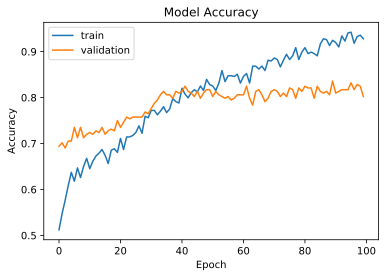

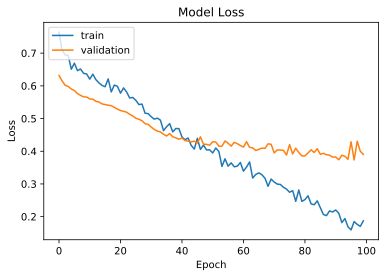

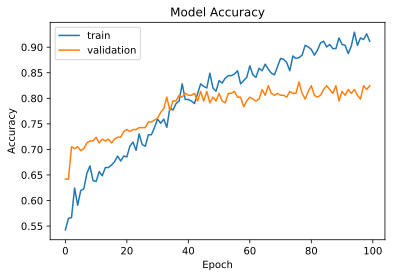

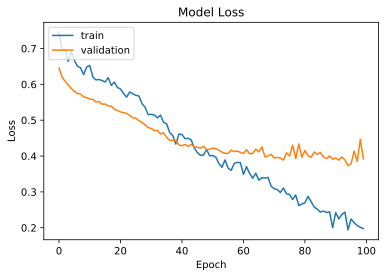

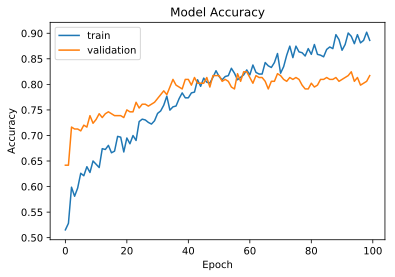

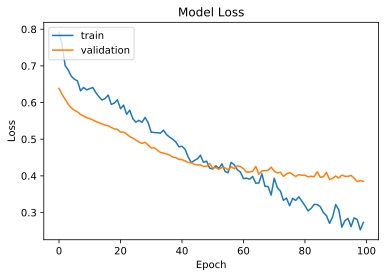

In [10]:
for history in histories:
#     print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [11]:
predictions = []

for model in models:
    name = model.name
    file_path="{}.weights.best.hdf5".format(name)

    # Load best weights
    model.load_weights(file_path)

    # Predict!
    prediction = model.predict(X_test, batch_size=128)
    prediction = list(map(lambda pred: int(pred[0] < pred[1]), prediction))
    predictions.append(prediction)

final_predictions = []

for i in range(len(predictions[0])):
    p = Counter((predictions[0][i], predictions[1][i], predictions[2][i]))
    final_predictions.append(p.most_common(1)[0][0])

# print(*predictions, sep="\n\n", end="\n\n")
# print(final_predictions)

In [12]:
sub = pd.read_csv("../input/gender_submission.csv")
sub.Survived = final_predictions

sub.to_csv("submission.csv", index=False)
sub.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
